In [1]:
# Fuseki IO Development V
## Refinement

# Attach dir one above to handle IDE subdir
import sys, os
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import repository
from rdflib import URIRef, Graph, Namespace


import pandas as pd
import html
import io
import pydotplus
from rdflib.tools.rdf2dot import rdf2dot
from IPython.display import display, Image
from urllib.error import HTTPError

from datetime import datetime

start = datetime.now()
import text_utils

* Owlready2 * Warning: optimized Cython parser module 'owlready2_optimized' is not available, defaulting to slower Python implementation
* Owlready2 * WARNING: ObjectProperty http://www.semanticweb.org/tomk/ontologies/2022/11/serialization#MappingMetaTarget belongs to more than one entity types: [owl.AnnotationProperty, owl.ObjectProperty, owl.topObjectProperty]; I'm trying to fix it...
* Owlready2 * Running HermiT...
    java -Xmx2000M -cp /home/tomk/environment/devpy/lib/python3.10/site-packages/owlready2/hermit:/home/tomk/environment/devpy/lib/python3.10/site-packages/owlready2/hermit/HermiT.jar org.semanticweb.HermiT.cli.CommandLine -c -O -D -I file:////tmp/tmp1hfx7xa_


Serialization.Meta [Serialization.SerializationMetaData]
Serialization.TranslationMapping [Serialization.SerializationSpecs]
Serialization.MappingKVPair [Serialization.SerializationSpecs]
Serialization.Serialization [Serialization.SerializationSpecs]
Serialization.Mapping [Serialization.SerializationSpecs]
Serialization.BatchDefinition [Serialization.SerializationSpecs]
Serialization.SerializationSpecs [Serialization.SerializationMetaData]
Serialization.BatchNode [Serialization.DataLoad]
Serialization.DataLoad [Serialization.SerializationMetaData]
Serialization.SerializationMetaData [owl.Thing]
Serialization.DataPropertyMapping [Serialization.Mapping]
Serialization.MetaDataProperty [Serialization.Meta]
Serialization.EntityMapping [Serialization.Mapping]
Serialization.MetaClass [Serialization.Meta]
Serialization.JobNode [Serialization.DataLoad]
Serialization.MetaProperty [Serialization.Meta]
Serialization.MetaStaticProperty [Serialization.Meta]
Serialization.PropertyMapping [Serializati

* Owlready2 * HermiT took 0.6149733066558838 seconds
* Owlready * (NB: only changes on entities loaded in Python are shown, other changes are done but not listed)


In [2]:
def visualize(g):
    stream = io.StringIO()
    rdf2dot(g, stream, opts = {display})
    #print(stream.getvalue())
    dg = pydotplus.graph_from_dot_data(stream.getvalue())
    png = dg.create_png()

    display(Image(png))

def t2rdflibg(triples): #triples to rdflib graph
    g = Graph()
    for t in triples:
        g.add(t)
    return g

def get_field(v):
    if isinstance(v,str):
        return html.escape(str(v))
    elif isinstance(v,(int, float)):
        if pd.isnull(v):
            return None
        else:
            return v
    elif v is None or isinstance(v,pd.Null):
        return None

In [3]:
store_type="jena"
store_type="memory"
repo = repository.Repository(store_type=store_type)

In [4]:
# Optional Delete data hosted in master and discourse database graphs
do="Yes"
#do="No"

if do == "Yes" and store_type != "memory":
    repo.truncate_graph(repo.master_graph_uri)
    repo.truncate_graph(repo.discourse_graph_uri)
    

In [5]:
cqr=repo.run_cached_query("get_discourse_details.sparql")
cqr

PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX disco: <http://www.semanticweb.org/tomk/ontologies/2022/11/discourse#> 
PREFIX dcterms: <http://purl.org/dc/terms/> 
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#> 

select ?g ?discourse ?name ?title ?description ?created ?hash (COUNT(?declaration) as ?declarations) (COUNT(distinct ?psubject) as ?entities)

WHERE {
  GRAPH ?g
  {
      ?discourse a disco:Discourse.
      ?discourse dcterms:title ?title.
      ?discourse rdfs:label ?name.
      ?discourse dcterms:description ?description.
      ?discourse dcterms:created ?created .
      ?discourse disco:DiscourseHash ?hash .
      ?discourse disco:DiscourseContains+ ?declaration .
      ?declaration a disco:Declaration .
      ?posit_type rdfs:subPropertyOf* disco:Posits .
      ?declaration disco:Asserts ?assertion.
      ?assertion disco:Subject ?psubject.
  }
}
GROUP BY ?g ?discourse ?name ?title ?description ?created ?hash


[]

In [6]:
repo.register_serialization("../sample_ser.rdf")
repo.register_serialization("../DMEAR_ser.rdf")

In [7]:
file_dtypes = {'ModelDomain': str,
 'Model': str,
 'ModelType': str,
 'Class': str,
 'ClassDescription': str,
 'Attribute': str,
 'AttributeDescription': str,
 'DataType': str,
 'Context': str,
 'SubContext': str,
 'Nulls': str,
 'IsPK': str,
 'Relationship': str,
 'FromClass': str,
 'FromAttribute': str,
 'FromCardinality': str,
 'ToClass': str,
 'ToAttribute': str,
 'ToCardinality': str}


In [8]:
mpd = {"created" : "2023-04-10", 
                   "creator" : "tomk", 
                   "description" : "Sample ERD model version 1", 
                   "title" : "inventory ERD", 
                   "modified" : "2023-04-10"}

metadata_payload = repo.meta_data_package_template( mpd )
title = "Inventory ERD v1.0"
model_data = pd.read_csv(r"../sample/inventory_v1.csv", index_col="Sequence", dtype=file_dtypes)
datarows = [dict({rk:get_field(rv) for rk, rv in r.items()}) for i,r in model_data.iterrows()]
repo.load_serialization_to_discourse("Data Model Entity Attribute Relation Serialization", mpd['title'], metadata_payload, datarows)

//////LOCATE1/////
0:00:00.018613 for 93 from 9
//////LOCATE2/////
self.members: 93
0:00:00.076048 for 1218 triples


In [9]:
mpd = {"created" : "2023-04-11", 
                   "creator" : "tomk", 
                   "description" : "Sample ERD model version 2", 
                   "title" : "inventory ERD", 
                   "modified" : "2023-04-11"}
metadata_payload = repo.meta_data_package_template( mpd )
title = "Inventory ERD v2.0"
model_data = pd.read_csv(r"../sample/inventory_v2.csv", index_col="Sequence", dtype=file_dtypes)
datarows = [dict({rk:get_field(rv) for rk, rv in r.items()}) for i,r in model_data.iterrows()]
repo.load_serialization_to_discourse("Data Model Entity Attribute Relation Serialization", mpd['title'], metadata_payload, datarows)

//////LOCATE1/////
0:00:00.032056 for 177 from 18
//////LOCATE2/////
self.members: 177
0:00:00.130139 for 2310 triples


In [10]:
mpd = {"created" : "2023-04-12", 
                   "creator" : "tomk", 
                   "description" : "Sample ERD model version 3", 
                   "title" : "inventory ERD", 
                   "modified" : "2023-04-12"}
metadata_payload = repo.meta_data_package_template( mpd )
title = "Inventory ERD v3.0"
model_data = pd.read_csv(r"../sample/inventory_v3.csv", index_col="Sequence", dtype=file_dtypes)
datarows = [dict({rk:get_field(rv) for rk, rv in r.items()}) for i,r in model_data.iterrows()]
repo.load_serialization_to_discourse("Data Model Entity Attribute Relation Serialization", mpd['title'], metadata_payload, datarows)

//////LOCATE1/////
0:00:00.068006 for 412 from 44
//////LOCATE2/////
self.members: 412
0:00:00.338616 for 5365 triples


In [11]:
mpd = {"created" : "2023-04-13", 
                   "creator" : "tomk", 
                   "description" : "Sample ERD model version 4", 
                   "title" : "inventory ERD", 
                   "modified" : "2023-04-13"}
metadata_payload = repo.meta_data_package_template( mpd )
title = "Inventory ERD v4.0"
model_data = pd.read_csv(r"../sample/inventory_v4.csv", index_col="Sequence", dtype=file_dtypes)
datarows = [dict({rk:get_field(rv) for rk, rv in r.items()}) for i,r in model_data.iterrows()]
repo.load_serialization_to_discourse("Data Model Entity Attribute Relation Serialization", mpd['title'], metadata_payload, datarows)

//////LOCATE1/////
0:00:00.072745 for 439 from 47
//////LOCATE2/////
self.members: 439
0:00:00.300347 for 5716 triples


In [12]:
repo.discourse_hashes

[('0bc32fc7473e-64a3-ef0d-ce58ab87f045',
  'http://www.semanticweb.org/tomk/ontologies/2022/11/5de58207b77b4bb8a8da0fc124717377'),
 ('b2431b6825e5-b596-af50-af720880ead4',
  'http://www.semanticweb.org/tomk/ontologies/2022/11/e31485ffd6e6431c97ec43e8a729f89c'),
 ('4057da8c629b-9711-0c67-ff9e477a6ee6',
  'http://www.semanticweb.org/tomk/ontologies/2022/11/a6fa10adb51249dfb13136c61c2780cb'),
 ('42079f3f1119-6d48-3b96-b2f9c178ec21',
  'http://www.semanticweb.org/tomk/ontologies/2022/11/aef6d1cf8d2a497ea40457b300aab333')]

In [13]:
qr = repo.run_cached_query("get_discourse_details.sparql")
qr_df = pd.DataFrame(qr)
qr_df

PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX disco: <http://www.semanticweb.org/tomk/ontologies/2022/11/discourse#> 
PREFIX dcterms: <http://purl.org/dc/terms/> 
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#> 

select ?g ?discourse ?name ?title ?description ?created ?hash (COUNT(?declaration) as ?declarations) (COUNT(distinct ?psubject) as ?entities)

WHERE {
  GRAPH ?g
  {
      ?discourse a disco:Discourse.
      ?discourse dcterms:title ?title.
      ?discourse rdfs:label ?name.
      ?discourse dcterms:description ?description.
      ?discourse dcterms:created ?created .
      ?discourse disco:DiscourseHash ?hash .
      ?discourse disco:DiscourseContains+ ?declaration .
      ?declaration a disco:Declaration .
      ?posit_type rdfs:subPropertyOf* disco:Posits .
      ?declaration disco:Asserts ?assertion.
      ?assertion disco:Subject ?psubject.
  }
}
GROUP BY ?g ?discourse ?name ?title ?description ?created ?hash


,g,discourse,name,title,description,created,hash,declarations,entities
0,http://discourse,http://www.semanticweb.org/tomk/ontologies/202...,discourse_inventory ERD,inventory ERD,Sample ERD model version 1,2023-04-10,0bc32fc7473e-64a3-ef0d-ce58ab87f045,93,13
1,http://discourse,http://www.semanticweb.org/tomk/ontologies/202...,discourse_inventory ERD,inventory ERD,Sample ERD model version 2,2023-04-11,b2431b6825e5-b596-af50-af720880ead4,177,24
2,http://discourse,http://www.semanticweb.org/tomk/ontologies/202...,discourse_inventory ERD,inventory ERD,Sample ERD model version 3,2023-04-12,4057da8c629b-9711-0c67-ff9e477a6ee6,412,56
3,http://discourse,http://www.semanticweb.org/tomk/ontologies/202...,discourse_inventory ERD,inventory ERD,Sample ERD model version 4,2023-04-13,42079f3f1119-6d48-3b96-b2f9c178ec21,439,59


In [14]:
qr

[{'g': 'http://discourse',
  'discourse': 'http://www.semanticweb.org/tomk/ontologies/2022/11/5de58207b77b4bb8a8da0fc124717377',
  'name': 'discourse_inventory ERD',
  'title': 'inventory ERD',
  'description': 'Sample ERD model version 1',
  'created': '2023-04-10',
  'hash': '0bc32fc7473e-64a3-ef0d-ce58ab87f045',
  'declarations': 93,
  'entities': 13},
 {'g': 'http://discourse',
  'discourse': 'http://www.semanticweb.org/tomk/ontologies/2022/11/e31485ffd6e6431c97ec43e8a729f89c',
  'name': 'discourse_inventory ERD',
  'title': 'inventory ERD',
  'description': 'Sample ERD model version 2',
  'created': '2023-04-11',
  'hash': 'b2431b6825e5-b596-af50-af720880ead4',
  'declarations': 177,
  'entities': 24},
 {'g': 'http://discourse',
  'discourse': 'http://www.semanticweb.org/tomk/ontologies/2022/11/a6fa10adb51249dfb13136c61c2780cb',
  'name': 'discourse_inventory ERD',
  'title': 'inventory ERD',
  'description': 'Sample ERD model version 3',
  'created': '2023-04-12',
  'hash': '4057

In [15]:
qi = qr_df.query("description in ['Sample ERD model version 3', 'Sample ERD model version 4'] ").index.values
qi

array([2, 3])

In [16]:
dict(qr_df.iloc[3])

{'g': 'http://discourse',
 'discourse': 'http://www.semanticweb.org/tomk/ontologies/2022/11/aef6d1cf8d2a497ea40457b300aab333',
 'name': 'discourse_inventory ERD',
 'title': 'inventory ERD',
 'description': 'Sample ERD model version 4',
 'created': '2023-04-13',
 'hash': '42079f3f1119-6d48-3b96-b2f9c178ec21',
 'declarations': 439,
 'entities': 59}

In [33]:
d1 = qr_df.iloc[qi[0]]['discourse']
d2 = qr_df.iloc[qi[1]]['discourse']
#get_posits_sparql = sparql.replace("%%p1%%", ",".join([d1,d2]))

d1,d2

('http://www.semanticweb.org/tomk/ontologies/2022/11/a6fa10adb51249dfb13136c61c2780cb',
 'http://www.semanticweb.org/tomk/ontologies/2022/11/aef6d1cf8d2a497ea40457b300aab333')

In [34]:

qr = repo.run_cached_query("get_discourse_posits_parms_discourse_iris.sparql", parameters=[",".join([URIRef(d1).n3(),URIRef(d2).n3()])], native_rdflib=True)
#results = list([{k:v[e] for e,k in enumerate([v.n3()[1:] for v in qr.vars])} for v in qr])
dcontents = pd.DataFrame(qr)
#set(dcontents['p'])
dcontents

('%%p0%%', '<http://www.semanticweb.org/tomk/ontologies/2022/11/a6fa10adb51249dfb13136c61c2780cb>,<http://www.semanticweb.org/tomk/ontologies/2022/11/aef6d1cf8d2a497ea40457b300aab333>')
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX disco: <http://www.semanticweb.org/tomk/ontologies/2022/11/discourse#> 
PREFIX dcterms: <http://purl.org/dc/terms/> 
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#> 

select ?g ?discourse ?assertion ?refutation ?posit ?s ?p ?o
WHERE {
  GRAPH ?g
  {
      ?discourse a disco:Discourse.
      ?discourse disco:DiscourseContains+ ?declaration .
      ?declaration a disco:Declaration .
        OPTIONAL { ?declaration disco:Asserts ?assertion. 
                   ?assertion disco:Subject ?s.
                   ?assertion disco:Predicate ?p.
                   ?assertion disco:Object ?o.
                   }
        OPTIONAL { ?declaration disco:Refutes ?refutation. 
                   ?refutation disco:Subject ?s.
                   ?refuta

,g,discourse,assertion,refutation,posit,s,p,o
0,http://discourse,http://www.semanticweb.org/tomk/ontologies/202...,http://www.semanticweb.org/tomk/ontologies/202...,None,None,http://www.semanticweb.org/tomk/ontologies/202...,http://www.semanticweb.org/tomk/ontologies/202...,datetime
1,http://discourse,http://www.semanticweb.org/tomk/ontologies/202...,http://www.semanticweb.org/tomk/ontologies/202...,None,None,http://www.semanticweb.org/tomk/ontologies/202...,http://www.semanticweb.org/tomk/ontologies/202...,No
2,http://discourse,http://www.semanticweb.org/tomk/ontologies/202...,http://www.semanticweb.org/tomk/ontologies/202...,None,None,http://www.semanticweb.org/tomk/ontologies/202...,http://www.semanticweb.org/tomk/ontologies/202...,No
3,http://discourse,http://www.semanticweb.org/tomk/ontologies/202...,http://www.semanticweb.org/tomk/ontologies/202...,None,None,http://www.semanticweb.org/tomk/ontologies/202...,http://www.semanticweb.org/tomk/ontologies/202...,integer
4,http://discourse,http://www.semanticweb.org/tomk/ontologies/202...,http://www.semanticweb.org/tomk/ontologies/202...,None,None,http://www.semanticweb.org/tomk/ontologies/202...,http://www.semanticweb.org/tomk/ontologies/202...,_.Simple ERD Model - Inventory.Staff.staff_id
...,...,...,...,...,...,...,...,...
846,http://discourse,http://www.semanticweb.org/tomk/ontologies/202...,http://www.semanticweb.org/tomk/ontologies/202...,None,None,http://www.semanticweb.org/tomk/ontologies/202...,http://www.semanticweb.org/tomk/ontologies/202...,Assigned role to this member of staff
847,http://discourse,http://www.semanticweb.org/tomk/ontologies/202...,http://www.semanticweb.org/tomk/ontologies/202...,None,None,http://www.semanticweb.org/tomk/ontologies/202...,http://www.semanticweb.org/tomk/ontologies/202...,No
848,http://discourse,http://www.semanticweb.org/tomk/ontologies/202...,http://www.semanticweb.org/tomk/ontologies/202...,None,None,http://www.semanticweb.org/tomk/ontologies/202...,http://www.semanticweb.org/tomk/ontologies/202...,Unique Id for this order item
849,http://discourse,http://www.semanticweb.org/tomk/ontologies/202...,http://www.semanticweb.org/tomk/ontologies/202...,None,None,http://www.semanticweb.org/tomk/ontologies/202...,http://www.w3.org/1999/02/22-rdf-syntax-ns#type,http://www.semanticweb.org/tomk/ontologies/202...


In [35]:

dcontents['triple'] = dcontents.apply(lambda x : tuple([x['s'], x['p'], x['o']]), axis=1)
dcd = dcontents.groupby(['discourse'])['triple'].agg(set).to_dict()

In [36]:
d1, d2

('http://www.semanticweb.org/tomk/ontologies/2022/11/a6fa10adb51249dfb13136c61c2780cb',
 'http://www.semanticweb.org/tomk/ontologies/2022/11/aef6d1cf8d2a497ea40457b300aab333')

In [37]:
from rdflib.util import from_n3
URIRef(d1)

rdflib.term.URIRef('http://www.semanticweb.org/tomk/ontologies/2022/11/a6fa10adb51249dfb13136c61c2780cb')

In [38]:
dcd.keys()

dict_keys([rdflib.term.URIRef('http://www.semanticweb.org/tomk/ontologies/2022/11/a6fa10adb51249dfb13136c61c2780cb'), rdflib.term.URIRef('http://www.semanticweb.org/tomk/ontologies/2022/11/aef6d1cf8d2a497ea40457b300aab333')])

In [39]:
dcd.get(d1)

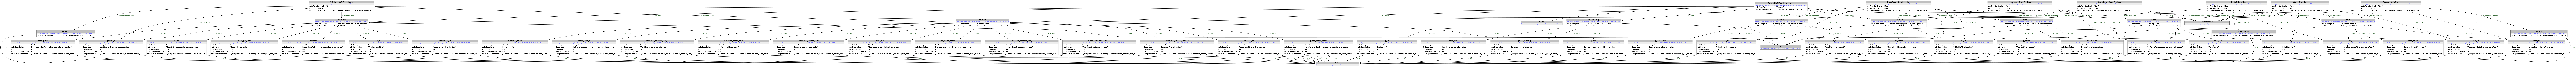

In [40]:
s1 = dcd.get(URIRef(d1))
s2 = dcd.get(URIRef(d2))
visualize(t2rdflibg(s1))

In [41]:
def typed_dictionary_from_triples(triple_set):
    type_d={}
    for t in triple_set:
        if t[1]==URIRef("http://www.w3.org/1999/02/22-rdf-syntax-ns#type"):
            if t[2] not in type_d.keys():
                type_d[t[2]]=set([t[0]])
            else:
                type_d[t[2]].add(t[0])
                
    return type_d


def diffset(S1, S2):
    # Given two input sets, s1 and s2, return the Left difference, Intersection and Right difference between them
    L = S1.difference(S2)
    I = S1.intersection(S2)
    R = S2.difference(S1)
    return L,I,R

def LIR_test(triple, LIR_tuple):
    for e,s in enumerate(LIR_tuple):
        if triple in s:
            return e
    return None
    

def property_per_entity(triple_set, entity):
    property_d={}
    for t in triple_set:
        if t[0] == entity:
            if t[1] not in property_d.keys():
                property_d[t[1]]=set([t[2]])
            else:
                property_d[t[1]].add(t[2])
    return property_d

def retrieve_property_meta(triple_set, LIR_tuple, subject, predicate):
    meta_collection=[]
    for s,p,o in triple_set:
        if s==subject and p==predicate:
            LIR_loc=LIR_test((s,p,o), LIR_tuple)
            meta_collection.append((LIR_loc, o))
    return meta_collection
            
    
    

In [47]:
def DMEAR_vizdiff_to_dot(S1, S2):
    rdf_type_uri = URIRef("http://www.w3.org/1999/02/22-rdf-syntax-ns#type")
    class_uri = URIRef('http://www.semanticweb.org/tomk/ontologies/2022/9/datamodel#Class')
    relation_uri = URIRef('http://www.semanticweb.org/tomk/ontologies/2022/9/datamodel#Relationship')
    attribute_uri = URIRef('http://www.semanticweb.org/tomk/ontologies/2022/9/datamodel#Attribute')
    L, I, R = diffset(S1, S2)
    obj_dict = typed_dictionary_from_triples(S1.union(S2))
    entities=[]
    ent_node_dir={}
    DMEAR_types = [ URIRef('http://www.semanticweb.org/tomk/ontologies/2022/9/datamodel#Model'), 
                    URIRef('http://www.semanticweb.org/tomk/ontologies/2022/9/datamodel#Class'),
                    URIRef('http://www.semanticweb.org/tomk/ontologies/2022/9/datamodel#Attribute'), 
                    URIRef('http://www.semanticweb.org/tomk/ontologies/2022/9/datamodel#Relationship')
                    ]
    for e,entity in enumerate(obj_dict[class_uri]):
        node_name=f"node_{e}"
        ent_node_dir[entity]=node_name
        def_triple = (entity, rdf_type_uri, class_uri)
        LIR_loc = LIR_test(def_triple, (L,I,R))
        eprops = property_per_entity(S1.union(S2), entity)
        unique_ids = retrieve_property_meta(S1.union(S2), (L,I,R), entity, URIRef('http://www.semanticweb.org/tomk/ontologies/2022/11/serialization#UniqueIdentifier'))
        labels = retrieve_property_meta(S1.union(S2), (L,I,R), entity, URIRef('http://www.w3.org/2000/01/rdf-schema#label'))
        descriptions = retrieve_property_meta(S1.union(S2), (L,I,R), entity, URIRef('http://www.semanticweb.org/tomk/ontologies/2022/9/datamodel#Description'))
        content_elements = retrieve_property_meta(S1.union(S2), (L,I,R), entity, URIRef('http://www.semanticweb.org/tomk/ontologies/2022/9/datamodel#Contains'))
        # possible filter on content_elements having type-assignments of Attribute
        attr_elements = []
        for a_lir, attribute in content_elements:
            aprops = property_per_entity(S1.union(S2), attribute)
            a_labels = retrieve_property_meta(S1.union(S2), (L,I,R), attribute, URIRef('http://www.w3.org/2000/01/rdf-schema#label'))
            a_descs = retrieve_property_meta(S1.union(S2), (L,I,R), attribute, URIRef('http://www.semanticweb.org/tomk/ontologies/2022/9/datamodel#Description'))
            a_dtypes = retrieve_property_meta(S1.union(S2), (L,I,R), attribute, URIRef('http://www.semanticweb.org/tomk/ontologies/2022/9/datamodel#DataType'))
            a_uniques = retrieve_property_meta(S1.union(S2), (L,I,R), attribute, URIRef('http://www.semanticweb.org/tomk/ontologies/2022/11/serialization#UniqueIdentifier'))
            a_optionalities = retrieve_property_meta(S1.union(S2), (L,I,R), attribute, URIRef('http://www.semanticweb.org/tomk/ontologies/2022/9/datamodel#Optionality'))
            a_pks = retrieve_property_meta(S1.union(S2), (L,I,R), attribute, URIRef('http://www.semanticweb.org/tomk/ontologies/2022/9/datamodel#isIdentifierForClass'))
            attribute_package = (attribute, a_lir, a_uniques, a_labels, a_descs, a_optionalities, a_pks)
            attr_elements.append(attribute_package)
        entities.append((entity, node_name, LIR_loc, unique_ids, labels, descriptions, attr_elements))
    relations=[]
    for relation in obj_dict[relation_uri]:
        #print(relation)
        rel_triple = (relation, rdf_type_uri, relation_uri)
        rel_lir = LIR_test(rel_triple, (L,I,R))
        rel_props = property_per_entity(S1.union(S2), relation)
        #for k in rel_props.keys():
        #    print (k)
        rel_from_class = retrieve_property_meta(S1.union(S2), (L,I,R), relation, URIRef('http://www.semanticweb.org/tomk/ontologies/2022/9/datamodel#RelationshipFromClass'))
        rel_to_class = retrieve_property_meta(S1.union(S2), (L,I,R), relation, URIRef('http://www.semanticweb.org/tomk/ontologies/2022/9/datamodel#RelationshipToClass'))
        rel_from_cardinality = retrieve_property_meta(S1.union(S2), (L,I,R), relation, URIRef('http://www.semanticweb.org/tomk/ontologies/2022/9/datamodel#RelationshipFromCardinality'))
        rel_to_cardinality = retrieve_property_meta(S1.union(S2), (L,I,R), relation, URIRef('http://www.semanticweb.org/tomk/ontologies/2022/9/datamodel#RelationshipToCardinality'))
        rel_from_attribute = retrieve_property_meta(S1.union(S2), (L,I,R), relation, URIRef('http://www.semanticweb.org/tomk/ontologies/2022/9/datamodel#RelationshipFromAttribute'))
        rel_to_attribute = retrieve_property_meta(S1.union(S2), (L,I,R), relation, URIRef('http://www.semanticweb.org/tomk/ontologies/2022/9/datamodel#RelationshipToAttribute'))
        rel_unique = retrieve_property_meta(S1.union(S2), (L,I,R), relation, URIRef('http://www.semanticweb.org/tomk/ontologies/2022/11/serialization#UniqueIdentifier'))
        rel_label = retrieve_property_meta(S1.union(S2), (L,I,R), relation, URIRef('http://www.w3.org/2000/01/rdf-schema#label'))
        rel_type = retrieve_property_meta(S1.union(S2), (L,I,R), relation, URIRef('http://www.w3.org/1999/02/22-rdf-syntax-ns#type'))
        rel_package = (relation, rel_lir, 
                       rel_unique, rel_label, 
                       rel_from_class, rel_to_class, 
                       ent_node_dir[rel_from_class[0][1]],ent_node_dir[rel_to_class[0][1]],
                       rel_from_attribute, rel_to_attribute, 
                       rel_from_cardinality, rel_to_cardinality,
                       rel_type)
        
        relations.append(rel_package)
    
    
    ## Build up entities and relations in dot language

        

    
    #col_dir = { 0 : "'#068806'", 1 : "'#000000'", 2 : "'#880606'"}
    col_dir = { 0 : "RED", 1 : "BLACK", 2 : "GREEN"}
    fg_col_dir = { 0 : "#880606", 1 : "#000000", 2 : "#068806"}
    alt_col_dir = { 0 : "#EE8888", 1 : "#AAAAAA", 2 : "#88EE88"}
    #start = """digraph { \n graph [fontname = "helvetica"]; \n node [ fontname="DejaVu Sans" ] ; \n edge [fontname = "helvetica"]; \n"""
    start = """digraph { \n graph [fontname = "helvetica"]; \n node [ fontname="helvetica" ] ; \n edge [fontname = "helvetica"]; \n"""
     
 
 
    ent_content = ""
    for ents in entities:
        att_content=""
        node, col, alt_col, label, uri, escape_uri = ents[1], col_dir[ents[2]], alt_col_dir[ents[2]], ents[4][0][1], entity[0], "<br/>".join(text_utils.ww(html.escape(ents[5][0][1]),40))
        if len (ents[6])>0:
            
            attrstr = f"""<tr><td align='left' bgcolor='{alt_col}'><font point-size='12' color='#000000'><B>Attribute</B></font></td><td align='left' bgcolor='{alt_col}'><font point-size='12' color='#000000'><B>Identifier</B></font></td></tr>"""
            att_content=att_content+attrstr
        #print([(x[6][0][1].n3(), x[3][0][1].n3())for x in ents[6]])
        e_sort={"\"Yes\"":0, "\"No\"": 1}
        for att in sorted(ents[6], key=lambda x : (e_sort[x[6][0][1].n3()], x[3][0][1].n3())):
            attr=att[3][0][1]
            pk=att[6][0][1]
            attr_lir = att[1]
            
            attr_col=fg_col_dir[attr_lir]
            #print(attr_col)
            if attr_lir != 0:
                attrstr = f"""<tr><td align='left'><font point-size='12' color='{attr_col}'>{attr}</font></td><td align='left'><font point-size='12' color='{attr_col}'>{pk}</font></td></tr>"""
            else:
                attrstr = f"""<tr><td align='left'><font point-size='12' color='{attr_col}'><s>{attr}</s></font></td><td align='left'><font point-size='12' color='{attr_col}'><s>{pk}</s></font></td></tr>"""
            att_content=att_content+attrstr
        
        #print(label, col)

        entstr = f"""{node} [ shape=none, color={col} label=< <table color='{alt_col}'
         cellborder='1' cellspacing='0' border='1'><tr>
        <td colspan='2' bgcolor='{alt_col}'><B>{label}</B></td></tr><tr>
        <td href='{uri}' bgcolor='#ffffff' colspan='2' ALIGN='center'>
        <font point-size='10' color='#000000'>{escape_uri}</font>
        </td>
        </tr>{att_content}</table> > ] \n"""

        ent_content = ent_content + entstr
            
    
    relstr = ""

    
    for rels in relations:
        fromnode, tonode, rel_col, rel_label = rels[6], rels[7], col_dir[rels[1]], rels[3][0][1].n3()
        fg_rel_col = fg_col_dir[rels[1]]
        if rels[1]!=0:
            relstr = relstr + f"""\t{fromnode} -> {tonode} [ color={rel_col}, label=< <font point-size='10' color='{fg_rel_col}'>{rel_label}</font> > ] ;\n"""
        else:
            relstr = relstr + f"""\t{fromnode} -> {tonode} [ color={rel_col}, label=< <font point-size='10' color='{fg_rel_col}'><s>{rel_label}</s></font> > ] ;\n"""
        
    return start  + relstr + ent_content + "}"

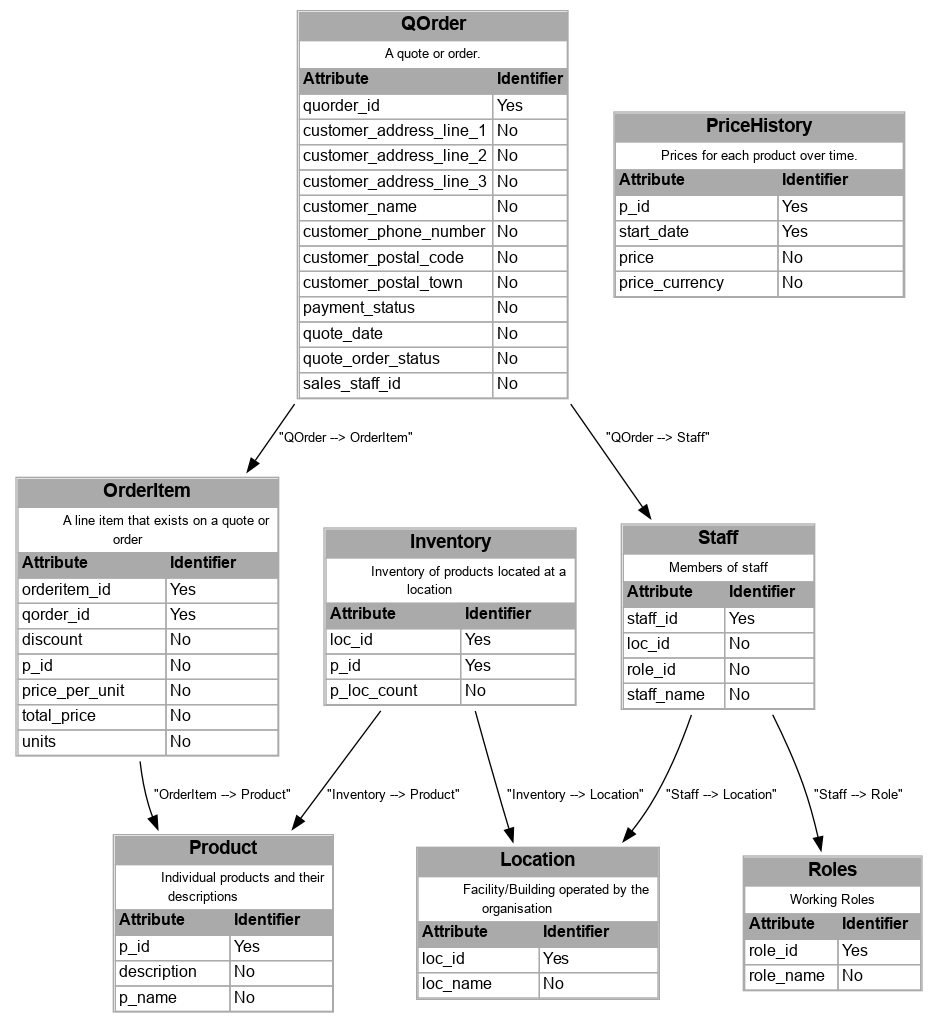

In [48]:
dot_text = DMEAR_vizdiff_to_dot(s1, s1)
#print(dot_text)
dg = pydotplus.graph_from_dot_data(dot_text)
png = dg.create_png()
display(Image(png))

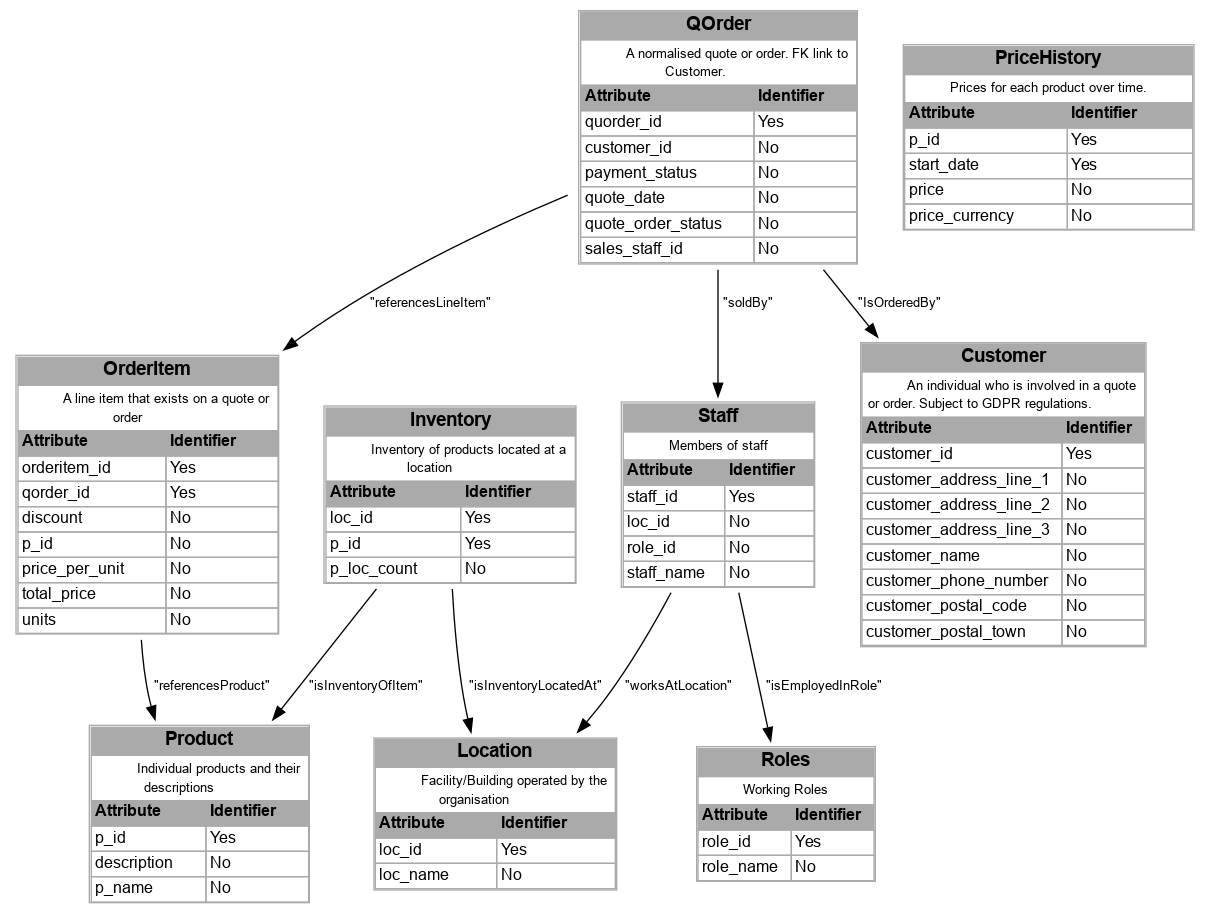

In [49]:
dot_text = DMEAR_vizdiff_to_dot(s2, s2)
#print(dot_text)
dg = pydotplus.graph_from_dot_data(dot_text)
png = dg.create_png()
display(Image(png))

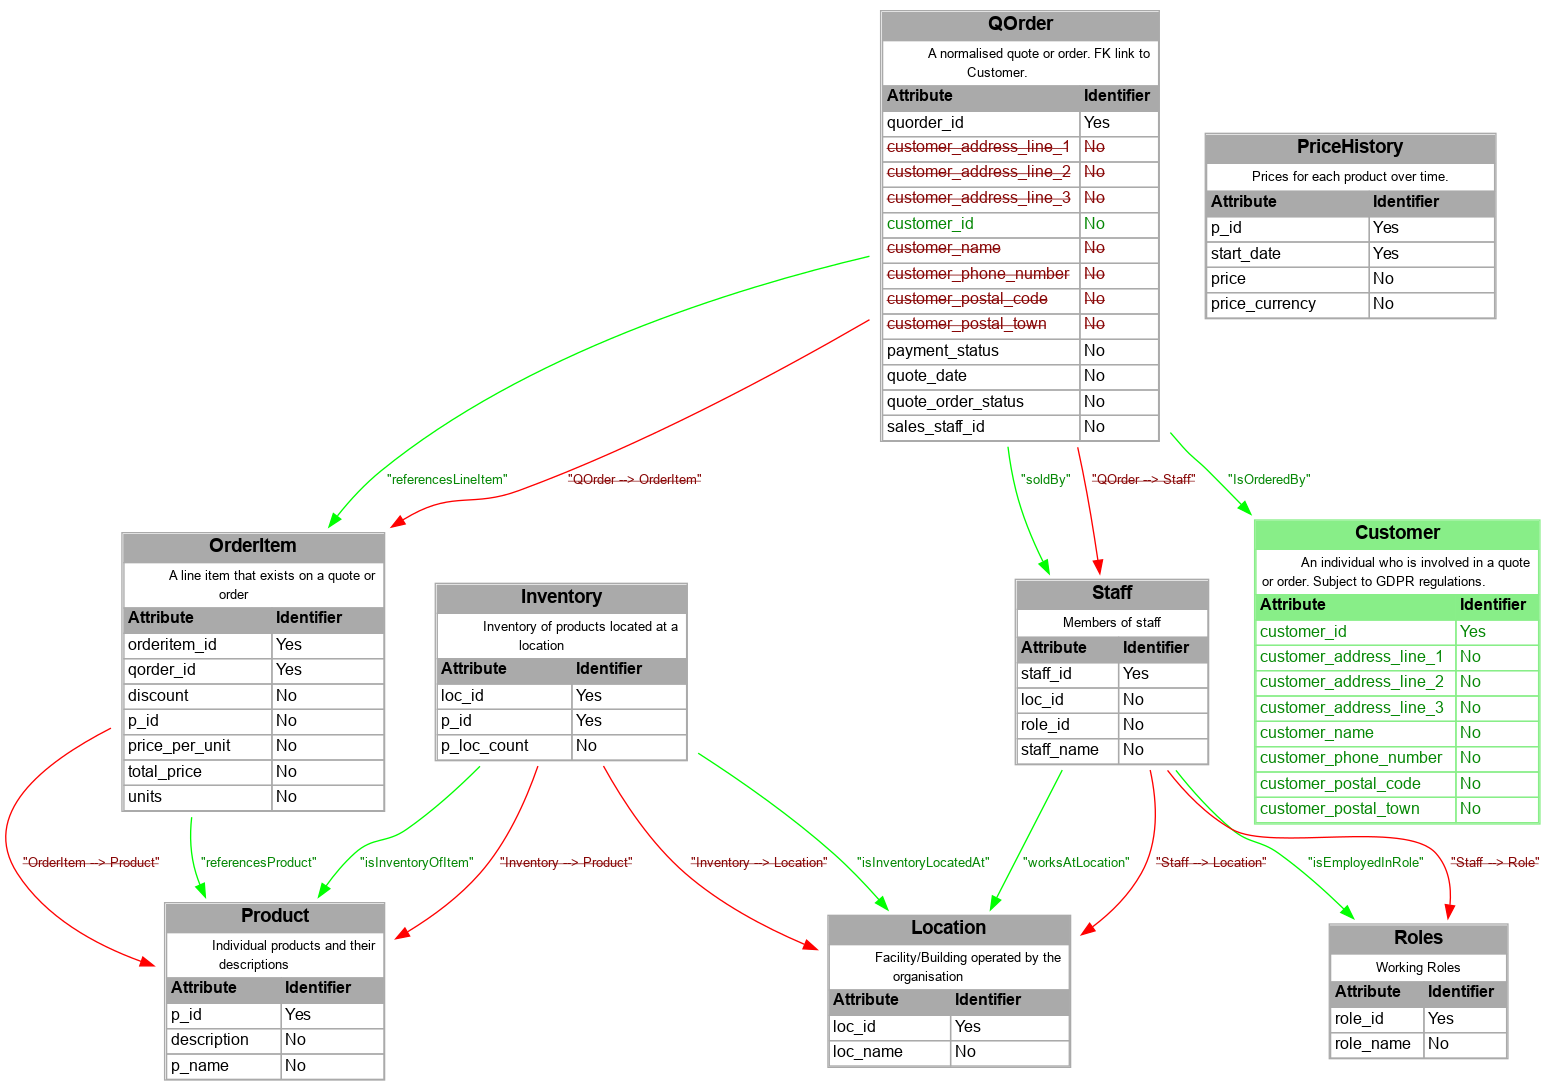

In [50]:
dot_text = DMEAR_vizdiff_to_dot(s1, s2)
#print(dot_text)
dg = pydotplus.graph_from_dot_data(dot_text)
png = dg.create_png()
display(Image(png))

In [46]:
timestamp = datetime.now()

elapsed = timestamp - start
print(elapsed)

0:03:12.443675


In [ ]:
dot_text = DMEAR_vizdiff_to_dot(s2, s2)
print(dot_text)
dg = pydotplus.graph_from_dot_data(dot_text)
png = dg.create_png()
display(Image(png))

In [ ]:
node = dg.get_nodes()[0]

In [ ]:
node.get_pos()

In [ ]:
dg.create_dot()

In [ ]:
node = dg.get_nodes()[0]

In [ ]:
import difflib

In [ ]:
a = "Mary had a little lamb. Its fleece as white as snow."
b = "Sue had a little puppy. Its eyes as dark as night."

In [ ]:
diffs = difflib.SequenceMatcher(None, a,b)

In [ ]:
diffs.a

In [ ]:
diffs.b

In [ ]:
from IPython.display import display
from IPython.display import HTML

In [ ]:
output=""
for c, i1, i2, j1, j2 in diffs.get_opcodes():
    if c in ["replace", "delete"]:
        print(c, b[j1:j2])
        output=output+"<font color=\"red\"><s>"+a[i1:i2]+"</s></font>"+"<font color=\"green\">" + b[j1:j2]+"</font>"
    elif c in "insert":
        print(c, b[j1:j2])
        output=output+"<font color=\"green\">" + b[j1:j2]+"</font>"
    else:
        print(c, b[j1:j2])
        output=output+b[j1:j2]
        
display(HTML(output))
        

In [ ]:
a = "This text starts the same. And ends the same way."
b = "This text starts the same, but includes a section that deviates from the original before ending the same way."

In [ ]:
diffs = difflib.SequenceMatcher(None, a,b)

output=""
for c, i1, i2, j1, j2 in diffs.get_opcodes():
    if c in ["replace", "delete"]:
        print(c, b[j1:j2])
        output=output+"<font color=\"red\"><s>"+a[i1:i2]+"</s></font>"+"<font color=\"green\">" + b[j1:j2]+"</font>"
    elif c in "insert":
        print(c, b[j1:j2])
        output=output+"<font color=\"green\">" + b[j1:j2]+"</font>"
    else:
        print(c, b[j1:j2])
        output=output+b[j1:j2]
        
display(HTML(output))
        

In [ ]:
diffs.get_opcodes()